#**Detecting and Mitigating Malicious Manipulations in Satellite Imagery Through Watermarking**



##Install and Load Required Packages

In [ ]:
!pip install rasterio einops -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.2 MB/s eta 0:00:00


In [ ]:
import zipfile
import os
import argparse
import numpy as np
import pandas as pd
import random
import einops
import time
import itertools
from pathlib import Path
import rasterio
from tqdm import tqdm
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from PIL import Image, ImageDraw, ImageFont
import random
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix ,classification_report, precision_score, recall_score, accuracy_score, f1_score, roc_auc_score, roc_curve
import torch
from torch import nn, Tensor
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torchvision.datasets import EuroSAT
from torchvision.utils import save_image
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from transformers import ViTModel, ViTConfig, ViTForImageClassification
from torchvision.transforms import Compose, Resize, ToTensor
from torchvision.utils import save_image, make_grid
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

##Preprocess Dataset

### Obtain Dataset and Organize Data

In [ ]:
# Define the root directory where you want the dataset to be downloaded
root_dir = Path('/content/')
zip_path = '/content/eurosat/EuroSAT.zip'


# Download and setup the EuroSAT dataset
eurosat_dataset = EuroSAT(root=root_dir, download=True, transform=transforms.ToTensor())
os.remove(zip_path)

100%|██████████| 94280567/94280567 [00:07<00:00, 13164683.19it/s]


Extracting /content/eurosat/EuroSAT.zip to /content/eurosat


In [ ]:
def count_files_in_subdirectories(directory):
    if not os.path.exists(directory):
        print(f"The directory {directory} does not exist.")
        return

    for root, dirs, files in os.walk(directory):
        print(f"Directory: {root}")
        print("Number of files:", len(files))
directory_path = '/content/eurosat'
count_files_in_subdirectories(directory_path)

Directory: /content/eurosat
Number of files: 0
Directory: /content/eurosat/2750
Number of files: 0
Directory: /content/eurosat/2750/AnnualCrop
Number of files: 3000
Directory: /content/eurosat/2750/HerbaceousVegetation
Number of files: 3000
Directory: /content/eurosat/2750/Forest
Number of files: 3000
Directory: /content/eurosat/2750/Pasture
Number of files: 2000
Directory: /content/eurosat/2750/Industrial
Number of files: 2500
Directory: /content/eurosat/2750/SeaLake
Number of files: 3000
Directory: /content/eurosat/2750/PermanentCrop
Number of files: 2500
Directory: /content/eurosat/2750/Residential
Number of files: 3000
Directory: /content/eurosat/2750/River
Number of files: 2500
Directory: /content/eurosat/2750/Highway
Number of files: 2500


###Convert to Numpy Array

In [ ]:
# set the path to the directory containing the EuroSAT dataset
data_dir = '/content/eurosat/2750'
new_directory_path = '/content/EuroSat_np'
os.makedirs(new_directory_path, exist_ok=True)
# set the path to the directory where the npy files will be saved
output_dir = '/content/EuroSat_np'

# define a list of the class names in the dataset
class_names = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial',
               'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']

# loop over each class
for i in range(len(class_names)):
    # get the name of the current class
    class_name = class_names[i]

    # set the path to the directory containing the
    #  images for the current class
    class_dir = os.path.join(data_dir, class_name)

    # get a list of the filenames of the images for the current class
    image_filenames = os.listdir(class_dir)

    # initialize an empty array to hold the image data
    X = np.zeros((len(image_filenames), 64, 64, 3))

    # loop over each image in the current class
    for j in range(len(image_filenames)):
        # get the filename of the current image
        image_filename = image_filenames[j]

        # set the path to the current image
        image_path = os.path.join(class_dir, image_filename)

        #print(image_path)


        # open the image using rasterio
        with rasterio.open(image_path) as src:
            # read the image data as a numpy array
            image = src.read()

        # transpose the image data to the shape (3, 64, 64)
        image = np.transpose(image, (1, 2, 0))
        #np.float32(img)


        # add the image data to the X array
        X[j,:,:,:] = image

    # save the X array as an npy file
    np.save(os.path.join(output_dir, f'X{i}.npy'), X)

    # create an array of labels for the current class
    y = np.ones(len(image_filenames)) * i

    # save the y array as an npy file
    np.save(os.path.join(output_dir, f'y{i}.npy'), y)

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [ ]:
# set the path to the directory containing the npy files
data_dir = '/content/EuroSat_np'

# set the path to save the trained model
model_path = '/content/eurosat'

In [ ]:
# Load data
X, y = [], []
for i in range(10):  # X0.npy through X9.npy and corresponding y files.
    X_i = np.load(f'{data_dir}/X{i}.npy')
    y_i = np.load(f'{data_dir}/y{i}.npy')

    # Debug: Print the shape of each loaded part
    print(f'X{i}.npy shape: {X_i.shape}')

    X.append(X_i)
    y.append(y_i)

# Concatenate all parts into a single array
X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0)

# Final check on the full dataset
print("Total images loaded: ", X.shape)
print("Total labels loaded: ", y.shape)

X0.npy shape: (3000, 64, 64, 3)
X1.npy shape: (3000, 64, 64, 3)
X2.npy shape: (3000, 64, 64, 3)
X3.npy shape: (2500, 64, 64, 3)
X4.npy shape: (2500, 64, 64, 3)
X5.npy shape: (2000, 64, 64, 3)
X6.npy shape: (2500, 64, 64, 3)
X7.npy shape: (3000, 64, 64, 3)
X8.npy shape: (2500, 64, 64, 3)
X9.npy shape: (3000, 64, 64, 3)
Total images loaded:  (27000, 64, 64, 3)
Total labels loaded:  (27000,)


### Understand the Dataset

In [ ]:
DATASET = "/content/eurosat/2750"

LABELS = os.listdir(DATASET)
print(LABELS)

['AnnualCrop', 'HerbaceousVegetation', 'Forest', 'Pasture', 'Industrial', 'SeaLake', 'PermanentCrop', 'Residential', 'River', 'Highway']


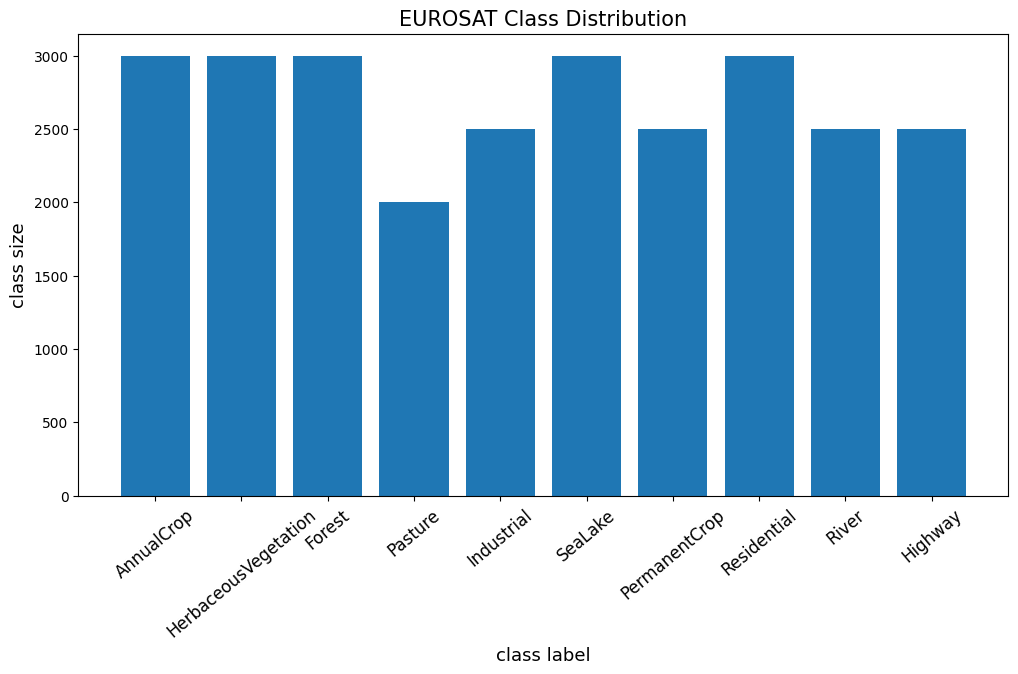

In [ ]:
# plot class distributions of whole dataset
counts = {}

for l in LABELS:
    counts[l] = len(os.listdir(os.path.join(DATASET, l)))


plt.figure(figsize=(12, 6))

plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.xticks(range(len(counts)), list(counts.keys()), fontsize=12, rotation=40)
plt.xlabel('class label', fontsize=13)
plt.ylabel('class size', fontsize=13)
plt.title('EUROSAT Class Distribution', fontsize=15);

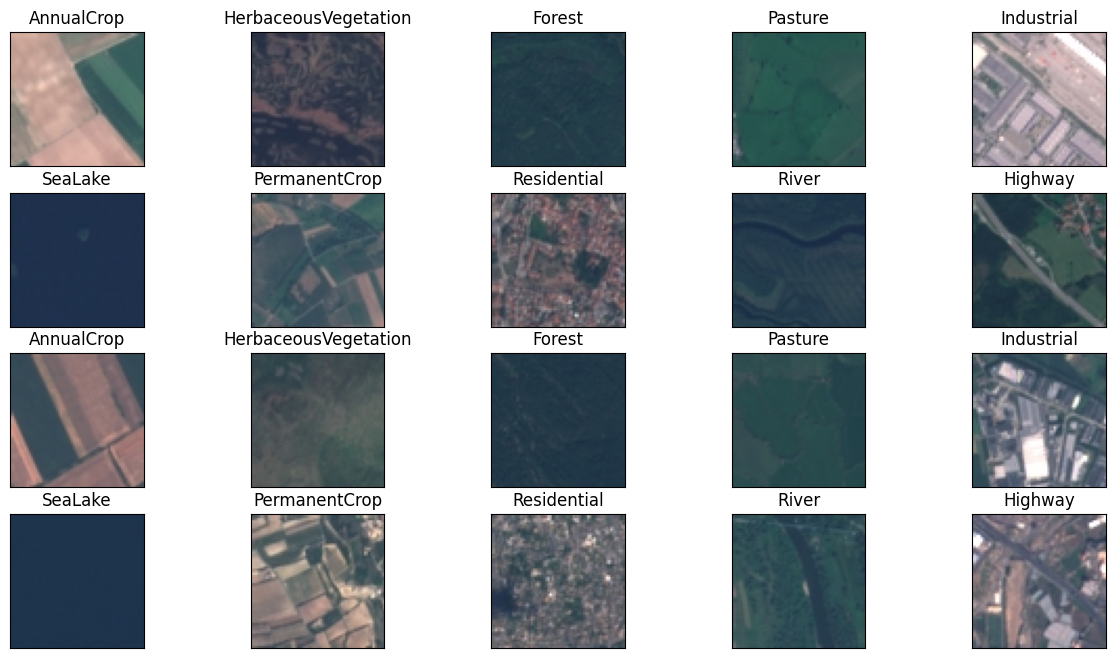

In [ ]:
img_paths = [os.path.join(DATASET, l, l+'_1000.jpg') for l in LABELS]

img_paths = img_paths + [os.path.join(DATASET, l, l+'_2000.jpg') for l in LABELS]

def plot_sat_imgs(paths):
    plt.figure(figsize=(15, 8))
    for i in range(20):
        plt.subplot(4, 5, i+1, xticks=[], yticks=[])
        img = Image.open(paths[i], 'r')
        plt.imshow(np.asarray(img))
        plt.title(paths[i].split('/')[-2])

plot_sat_imgs(img_paths)

In [ ]:
print(X.shape)

#X = rearrange(X, 'b h w c -> b c h w')

#print(X.shape)

(27000, 64, 64, 3)


### Split the Dataset into Training and Testing

In [ ]:
# split the data into training and testing sets
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# split the data
for train_idx, test_idx in split.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

### Apply the Watermark to the Dataset

In [ ]:
def apply_watermark(image_array, text='H', font_size=8, opacity=20):
    # Convert the numpy array to a PIL Image
    image = Image.fromarray(image_array.astype('uint8'), 'RGB')

    # Define the font
    font = ImageFont.load_default()

    # Create a drawing context to measure text
    dummy_image = Image.new("RGB", (1, 1))
    dummy_draw = ImageDraw.Draw(dummy_image)

    # Get the bounding box of the text
    text_width, text_height = dummy_draw.textbbox((0, 0), text, font=font)[2:]

    # Convert image to RGBA to add opacity
    image = image.convert("RGBA")
    overlay = Image.new("RGBA", image.size)
    draw = ImageDraw.Draw(overlay)

    # Randomize position within the boundaries of the image
    max_x = image.size[0] - text_width  # Width of image minus width of text
    max_y = image.size[1] - text_height  # Height of image minus height of text
    random_position = (random.randint(0, max_x), random.randint(0, max_y))

    # Text color with opacity
    text_color = (255, 255, 255, opacity)  # Adjust the opacity here

    # Place the text on the overlay image with partial opacity
    draw.text(random_position, text, font=font, fill=text_color)

    # Combine the overlay with the image
    watermarked_image = Image.alpha_composite(image, overlay)

    # Convert back to RGB to drop the alpha channel
    watermarked_image = watermarked_image.convert("RGB")

    # Convert back to numpy array
    return np.array(watermarked_image)

###Load the Preprocessed Dataset

In [ ]:
class EuroSATDataset(Dataset):
    def __init__(self, X, y, watermark_prob=0.5):
        self.X = X
        self.y = y
        self.watermark_prob = watermark_prob
        self.watermarks = np.random.rand(len(X)) < watermark_prob

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = self.X[idx]
        landscape_label = self.y[idx]
        watermark_label = self.watermarks[idx]

        # Apply watermark if flagged
        if watermark_label:
            image = apply_watermark(image)

        # Convert the image to a tensor and rearrange to 'channels first'
        image = torch.from_numpy(image).float()
        image = image.permute(2, 0, 1)  # Ensuring channels first format

        landscape_label = torch.tensor(landscape_label, dtype=torch.long)
        return image, landscape_label, watermark_label

    def save_dataset_images(dataset, root_dir):
    # Iterate over the dataset with a progress bar
      for i in tqdm(range(len(dataset)), desc="Saving images"):
        image, landscape_label, watermark_label = dataset[i]
        label_name = labels[landscape_label]  # Assuming landscape_label is the index in the labels list

        # Determine the subfolder based on the watermark label
        subfolder = "watermarked" if watermark_label else "non_watermarked"
        file_path = os.path.join(root_dir, label_name, subfolder, f"{i}.png")

        # Save the image
        save_image(image, file_path)

# Create the DataLoader for both training and testing datasets
train_dataset = EuroSATDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = EuroSATDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
# set the device to use for training and testing
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
print(len(train_loader))

675


In [ ]:
print(len(test_loader))

169


In [ ]:
root_dir = "/content/eurosat/2750/"
labels = ['Forest', 'HerbaceousVegetation', 'AnnualCrop', 'Industrial', 'PermanentCrop', 'SeaLake', 'Residential', 'River', 'Pasture', 'Highway']

# Create a directory for each label and subdirectories for watermarked and non-watermarked
for label in labels:
    os.makedirs(os.path.join(root_dir, label, "watermarked"), exist_ok=True)
    os.makedirs(os.path.join(root_dir, label, "non_watermarked"), exist_ok=True)


## Base Classification Model using ViT

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768, img_size: int = 224):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # using a conv layer instead of a linear one -> performance gains
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
        self.positions = nn.Parameter(torch.randn((img_size // patch_size) **2 + 1, emb_size))


    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        # prepend the cls token to the input
        x = torch.cat([cls_tokens, x], dim=1)
        # add position embedding
        x += self.positions
        return x

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 768, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        # fuse the queries, keys and values in one matrix
        self.qkv = nn.Linear(emb_size, emb_size * 3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)

    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values in num_heads
        qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3)
        queries, keys, values = qkv[0], qkv[1], qkv[2]
        # sum up over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)

        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out

In [ ]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

In [ ]:
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size: int, expansion: int = 4, drop_p: float = 0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

In [ ]:
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size: int = 768,
                 drop_p: float = 0.,
                 forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 ** kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))

In [ ]:
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int = 12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])


In [ ]:
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int = 768, n_classes: int = 1000):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, n_classes))

In [ ]:
class ViT(nn.Sequential):
    def __init__(self,
                in_channels: int = 3,
                patch_size: int = 16,
                emb_size: int = 768,
                img_size: int = 64,
                depth: int = 12,
                n_classes: int = 10,
                **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )

In [ ]:
summary(ViT().cuda(), (3, 64, 64), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 768, 4, 4]         590,592
         Rearrange-2              [-1, 16, 768]               0
    PatchEmbedding-3              [-1, 17, 768]               0
         LayerNorm-4              [-1, 17, 768]           1,536
            Linear-5             [-1, 17, 2304]       1,771,776
           Dropout-6            [-1, 8, 17, 17]               0
            Linear-7              [-1, 17, 768]         590,592
MultiHeadAttention-8              [-1, 17, 768]               0
           Dropout-9              [-1, 17, 768]               0
      ResidualAdd-10              [-1, 17, 768]               0
        LayerNorm-11              [-1, 17, 768]           1,536
           Linear-12             [-1, 17, 3072]       2,362,368
             GELU-13             [-1, 17, 3072]               0
          Dropout-14             [-1, 1

In [ ]:
model = ViT()
model=model.cuda()

In [ ]:
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 10


In [ ]:
print(torch.cuda.is_available())

True


In [ ]:
train_losses = []
train_accu = []

def train(epoch):
    print('Epoch : %d'%epoch)

    model.train()
    running_loss=0
    correct=0
    total=0
    for images, landscape_labels, _ in tqdm(train_loader):
        images = images.float().cuda()
        landscape_labels = landscape_labels.float().cuda()
        #print(images.size())
        #print(labels.size())
        # Forward pass
        #model = model.cuda()
        outputs = model(images)
        labels1= np.zeros((32,10))

        #labels1 = tensor.detach().cpu().numpy()
        for j in range(32):
            i=landscape_labels[j]
            i=int(i.item())
            # print(i)
            labels1[j][i]=1
        labels1=torch.from_numpy(labels1)
        #print(labels1.size())
        labels1=labels1.to(device='cuda')
        loss = criterion(outputs, labels1)


       # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    #Replaces pow(2.0) with abs() for L1 regularization

#     l2_lambda = 0.001
#     l2_norm = sum(p.pow(2.0).sum()
#                   for p in model.parameters())

#     loss = loss + l2_lambda * l2_norm


        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total += landscape_labels.size(0)
        correct += predicted.eq(landscape_labels).sum().item()

    train_loss=running_loss/len(train_loader)
    accu=100.*correct/total

    train_accu.append(accu)
    train_losses.append(train_loss)
    print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))


In [ ]:
eval_losses=[]
eval_accu=[]

def test(epoch):
    model.eval()

    running_loss=0
    correct=0
    total=0
    #print(test_loader)
    with torch.no_grad():
        for images, landscape_labels, _ in tqdm(train_loader):
            #images = images.to(device='cuda', dtype=torch.float)
            images = images.float().cuda()
            landscape_labels = landscape_labels.float().cuda()
            #labels = labels.to(device='cuda', dtype=torch.float)

            # Predict classes using the model
            outputs = model(images)
            #print(labels.size())
            t,y=outputs.shape
            # print(t)
            labels1= np.zeros((t,10))
            for j in range(t):
                i=landscape_labels[j]
                i=int(i.item())
                labels1[j][i]=1
            labels1=torch.from_numpy(labels1)
            #print(labels1.size())
            labels1=labels1.to(device='cuda')
            #outputs=outputs.tensor()
            loss= criterion(outputs,labels1)
            running_loss+=loss.item()


           # Compute accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += landscape_labels.size(0)
            correct += (predicted == landscape_labels).sum().item()

    test_loss=running_loss/len(test_loader)
    accu=100.*correct/total

    eval_losses.append(test_loss)
    eval_accu.append(accu)

    print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu))


### Run Model

In [ ]:
epochs = 70

# Start the time

start_time = time.time()
for epoch in range(1,epochs+1):
    train(epoch)
    # Save the model after training
    test(epoch)
    # Save the model after testing
# End the timer
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time

print('Training time: {:.2f} seconds'.format(training_time))

Epoch : 1


100%|██████████| 675/675 [00:30<00:00, 21.89it/s]


Train Loss: 1.670 | Accuracy: 37.949


100%|██████████| 675/675 [00:12<00:00, 54.75it/s]


Test Loss: 5.744 | Accuracy: 47.282
Epoch : 2


100%|██████████| 675/675 [00:29<00:00, 22.69it/s]


Train Loss: 1.288 | Accuracy: 53.042


100%|██████████| 675/675 [00:12<00:00, 52.54it/s]


Test Loss: 4.583 | Accuracy: 59.269
Epoch : 3


100%|██████████| 675/675 [00:30<00:00, 22.49it/s]


Train Loss: 1.247 | Accuracy: 55.370


100%|██████████| 675/675 [00:12<00:00, 54.34it/s]


Test Loss: 4.594 | Accuracy: 57.972
Epoch : 4


100%|██████████| 675/675 [00:30<00:00, 22.22it/s]


Train Loss: 1.074 | Accuracy: 61.102


100%|██████████| 675/675 [00:12<00:00, 52.47it/s]


Test Loss: 4.826 | Accuracy: 56.500
Epoch : 5


100%|██████████| 675/675 [00:30<00:00, 22.06it/s]


Train Loss: 1.002 | Accuracy: 63.676


100%|██████████| 675/675 [00:12<00:00, 54.62it/s]


Test Loss: 3.510 | Accuracy: 68.306
Epoch : 6


100%|██████████| 675/675 [00:29<00:00, 22.71it/s]


Train Loss: 1.035 | Accuracy: 62.556


100%|██████████| 675/675 [00:12<00:00, 54.78it/s]


Test Loss: 4.107 | Accuracy: 63.231
Epoch : 7


100%|██████████| 675/675 [00:29<00:00, 22.73it/s]


Train Loss: 0.917 | Accuracy: 66.782


100%|██████████| 675/675 [00:12<00:00, 54.58it/s]


Test Loss: 3.870 | Accuracy: 65.032
Epoch : 8


100%|██████████| 675/675 [00:29<00:00, 22.61it/s]


Train Loss: 0.977 | Accuracy: 65.134


100%|██████████| 675/675 [00:12<00:00, 54.19it/s]


Test Loss: 4.136 | Accuracy: 61.764
Epoch : 9


100%|██████████| 675/675 [00:30<00:00, 22.18it/s]


Train Loss: 1.273 | Accuracy: 54.681


100%|██████████| 675/675 [00:12<00:00, 52.40it/s]


Test Loss: 4.186 | Accuracy: 63.412
Epoch : 10


100%|██████████| 675/675 [00:30<00:00, 22.27it/s]


Train Loss: 1.031 | Accuracy: 63.259


100%|██████████| 675/675 [00:12<00:00, 54.74it/s]


Test Loss: 3.865 | Accuracy: 65.333
Epoch : 11


100%|██████████| 675/675 [00:29<00:00, 22.67it/s]


Train Loss: 0.919 | Accuracy: 66.880


100%|██████████| 675/675 [00:12<00:00, 54.78it/s]


Test Loss: 3.588 | Accuracy: 67.435
Epoch : 12


100%|██████████| 675/675 [00:29<00:00, 22.72it/s]


Train Loss: 1.045 | Accuracy: 62.972


100%|██████████| 675/675 [00:12<00:00, 54.92it/s]


Test Loss: 5.182 | Accuracy: 53.894
Epoch : 13


100%|██████████| 675/675 [00:29<00:00, 22.67it/s]


Train Loss: 1.073 | Accuracy: 61.741


100%|██████████| 675/675 [00:12<00:00, 54.70it/s]


Test Loss: 3.696 | Accuracy: 66.981
Epoch : 14


100%|██████████| 675/675 [00:29<00:00, 22.77it/s]


Train Loss: 1.252 | Accuracy: 54.718


100%|██████████| 675/675 [00:12<00:00, 54.28it/s]


Test Loss: 4.134 | Accuracy: 62.394
Epoch : 15


100%|██████████| 675/675 [00:30<00:00, 22.36it/s]


Train Loss: 1.037 | Accuracy: 62.417


100%|██████████| 675/675 [00:12<00:00, 52.68it/s]


Test Loss: 3.802 | Accuracy: 65.528
Epoch : 16


100%|██████████| 675/675 [00:30<00:00, 22.00it/s]


Train Loss: 1.065 | Accuracy: 62.162


100%|██████████| 675/675 [00:13<00:00, 51.80it/s]


Test Loss: 4.646 | Accuracy: 60.644
Epoch : 17


100%|██████████| 675/675 [00:30<00:00, 22.07it/s]


Train Loss: 0.976 | Accuracy: 65.051


100%|██████████| 675/675 [00:12<00:00, 53.05it/s]


Test Loss: 3.519 | Accuracy: 68.343
Epoch : 18


100%|██████████| 675/675 [00:30<00:00, 21.97it/s]


Train Loss: 1.097 | Accuracy: 61.287


100%|██████████| 675/675 [00:12<00:00, 52.51it/s]


Test Loss: 4.508 | Accuracy: 60.407
Epoch : 19


100%|██████████| 675/675 [00:30<00:00, 21.98it/s]


Train Loss: 1.053 | Accuracy: 62.634


100%|██████████| 675/675 [00:12<00:00, 52.11it/s]


Test Loss: 4.429 | Accuracy: 59.644
Epoch : 20


100%|██████████| 675/675 [00:30<00:00, 21.96it/s]


Train Loss: 0.982 | Accuracy: 64.755


100%|██████████| 675/675 [00:12<00:00, 52.77it/s]


Test Loss: 4.267 | Accuracy: 61.255
Epoch : 21


100%|██████████| 675/675 [00:30<00:00, 21.98it/s]


Train Loss: 0.911 | Accuracy: 66.972


100%|██████████| 675/675 [00:12<00:00, 53.02it/s]


Test Loss: 3.673 | Accuracy: 67.213
Epoch : 22


100%|██████████| 675/675 [00:30<00:00, 22.33it/s]


Train Loss: 0.919 | Accuracy: 67.125


100%|██████████| 675/675 [00:12<00:00, 54.41it/s]


Test Loss: 3.898 | Accuracy: 65.880
Epoch : 23


100%|██████████| 675/675 [00:29<00:00, 22.59it/s]


Train Loss: 0.869 | Accuracy: 68.875


100%|██████████| 675/675 [00:12<00:00, 54.96it/s]


Test Loss: 3.282 | Accuracy: 70.019
Epoch : 24


100%|██████████| 675/675 [00:29<00:00, 22.75it/s]


Train Loss: 1.177 | Accuracy: 57.847


100%|██████████| 675/675 [00:12<00:00, 54.58it/s]


Test Loss: 4.365 | Accuracy: 61.819
Epoch : 25


100%|██████████| 675/675 [00:29<00:00, 22.68it/s]


Train Loss: 1.100 | Accuracy: 60.542


100%|██████████| 675/675 [00:12<00:00, 54.48it/s]


Test Loss: 3.791 | Accuracy: 66.657
Epoch : 26


100%|██████████| 675/675 [00:29<00:00, 22.71it/s]


Train Loss: 0.943 | Accuracy: 66.347


100%|██████████| 675/675 [00:12<00:00, 55.21it/s]


Test Loss: 3.491 | Accuracy: 69.079
Epoch : 27


100%|██████████| 675/675 [00:29<00:00, 22.80it/s]


Train Loss: 0.986 | Accuracy: 64.944


100%|██████████| 675/675 [00:12<00:00, 54.59it/s]


Test Loss: 3.712 | Accuracy: 67.037
Epoch : 28


100%|██████████| 675/675 [00:29<00:00, 22.58it/s]


Train Loss: 0.882 | Accuracy: 68.157


100%|██████████| 675/675 [00:12<00:00, 54.87it/s]


Test Loss: 3.277 | Accuracy: 70.935
Epoch : 29


100%|██████████| 675/675 [00:29<00:00, 22.65it/s]


Train Loss: 0.901 | Accuracy: 67.727


100%|██████████| 675/675 [00:12<00:00, 54.87it/s]


Test Loss: 3.233 | Accuracy: 71.042
Epoch : 30


100%|██████████| 675/675 [00:29<00:00, 22.69it/s]


Train Loss: 0.844 | Accuracy: 69.417


100%|██████████| 675/675 [00:12<00:00, 54.29it/s]


Test Loss: 3.429 | Accuracy: 69.537
Epoch : 31


100%|██████████| 675/675 [00:29<00:00, 22.51it/s]


Train Loss: 0.912 | Accuracy: 67.634


100%|██████████| 675/675 [00:12<00:00, 53.71it/s]


Test Loss: 3.484 | Accuracy: 68.398
Epoch : 32


100%|██████████| 675/675 [00:29<00:00, 22.50it/s]


Train Loss: 0.834 | Accuracy: 70.236


100%|██████████| 675/675 [00:12<00:00, 54.64it/s]


Test Loss: 3.176 | Accuracy: 71.417
Epoch : 33


100%|██████████| 675/675 [00:29<00:00, 22.65it/s]


Train Loss: 0.884 | Accuracy: 68.685


100%|██████████| 675/675 [00:12<00:00, 54.60it/s]


Test Loss: 3.238 | Accuracy: 71.361
Epoch : 34


100%|██████████| 675/675 [00:29<00:00, 22.63it/s]


Train Loss: 0.879 | Accuracy: 68.611


100%|██████████| 675/675 [00:12<00:00, 55.37it/s]


Test Loss: 3.160 | Accuracy: 71.565
Epoch : 35


100%|██████████| 675/675 [00:29<00:00, 23.00it/s]


Train Loss: 0.852 | Accuracy: 69.690


100%|██████████| 675/675 [00:12<00:00, 55.80it/s]


Test Loss: 3.376 | Accuracy: 69.032
Epoch : 36


100%|██████████| 675/675 [00:29<00:00, 23.07it/s]


Train Loss: 0.860 | Accuracy: 68.940


100%|██████████| 675/675 [00:12<00:00, 55.45it/s]


Test Loss: 3.107 | Accuracy: 71.968
Epoch : 37


100%|██████████| 675/675 [00:29<00:00, 22.94it/s]


Train Loss: 0.822 | Accuracy: 70.917


100%|██████████| 675/675 [00:12<00:00, 55.61it/s]


Test Loss: 6.064 | Accuracy: 52.380
Epoch : 38


100%|██████████| 675/675 [00:29<00:00, 22.99it/s]


Train Loss: 1.110 | Accuracy: 61.171


100%|██████████| 675/675 [00:12<00:00, 55.41it/s]


Test Loss: 6.397 | Accuracy: 44.491
Epoch : 39


100%|██████████| 675/675 [00:29<00:00, 22.95it/s]


Train Loss: 1.042 | Accuracy: 63.421


100%|██████████| 675/675 [00:12<00:00, 54.97it/s]


Test Loss: 3.400 | Accuracy: 69.181
Epoch : 40


100%|██████████| 675/675 [00:29<00:00, 23.00it/s]


Train Loss: 0.922 | Accuracy: 67.519


100%|██████████| 675/675 [00:12<00:00, 56.13it/s]


Test Loss: 3.267 | Accuracy: 71.222
Epoch : 41


100%|██████████| 675/675 [00:29<00:00, 23.09it/s]


Train Loss: 0.801 | Accuracy: 71.176


100%|██████████| 675/675 [00:12<00:00, 56.02it/s]


Test Loss: 2.972 | Accuracy: 73.523
Epoch : 42


100%|██████████| 675/675 [00:29<00:00, 23.15it/s]


Train Loss: 0.781 | Accuracy: 71.912


100%|██████████| 675/675 [00:12<00:00, 55.71it/s]


Test Loss: 3.395 | Accuracy: 69.690
Epoch : 43


100%|██████████| 675/675 [00:29<00:00, 23.15it/s]


Train Loss: 0.804 | Accuracy: 71.245


100%|██████████| 675/675 [00:12<00:00, 56.05it/s]


Test Loss: 3.317 | Accuracy: 69.773
Epoch : 44


100%|██████████| 675/675 [00:29<00:00, 23.07it/s]


Train Loss: 0.823 | Accuracy: 70.375


100%|██████████| 675/675 [00:12<00:00, 55.85it/s]


Test Loss: 2.938 | Accuracy: 73.481
Epoch : 45


100%|██████████| 675/675 [00:29<00:00, 23.04it/s]


Train Loss: 0.810 | Accuracy: 70.801


100%|██████████| 675/675 [00:12<00:00, 55.57it/s]


Test Loss: 3.135 | Accuracy: 72.042
Epoch : 46


100%|██████████| 675/675 [00:29<00:00, 23.03it/s]


Train Loss: 0.860 | Accuracy: 69.523


100%|██████████| 675/675 [00:12<00:00, 55.52it/s]


Test Loss: 4.335 | Accuracy: 62.926
Epoch : 47


100%|██████████| 675/675 [00:29<00:00, 23.15it/s]


Train Loss: 0.892 | Accuracy: 68.079


100%|██████████| 675/675 [00:12<00:00, 55.85it/s]


Test Loss: 3.526 | Accuracy: 67.602
Epoch : 48


100%|██████████| 675/675 [00:29<00:00, 23.05it/s]


Train Loss: 0.808 | Accuracy: 70.852


100%|██████████| 675/675 [00:12<00:00, 56.01it/s]


Test Loss: 2.997 | Accuracy: 73.319
Epoch : 49


100%|██████████| 675/675 [00:29<00:00, 22.79it/s]


Train Loss: 0.769 | Accuracy: 72.444


100%|██████████| 675/675 [00:12<00:00, 54.54it/s]


Test Loss: 3.160 | Accuracy: 71.384
Epoch : 50


100%|██████████| 675/675 [00:30<00:00, 22.16it/s]


Train Loss: 0.806 | Accuracy: 71.315


100%|██████████| 675/675 [00:12<00:00, 52.67it/s]


Test Loss: 3.147 | Accuracy: 71.940
Epoch : 51


100%|██████████| 675/675 [00:29<00:00, 22.71it/s]


Train Loss: 0.772 | Accuracy: 72.282


100%|██████████| 675/675 [00:12<00:00, 55.37it/s]


Test Loss: 3.035 | Accuracy: 72.968
Epoch : 52


100%|██████████| 675/675 [00:29<00:00, 22.89it/s]


Train Loss: 0.784 | Accuracy: 71.537


100%|██████████| 675/675 [00:12<00:00, 55.34it/s]


Test Loss: 2.944 | Accuracy: 73.264
Epoch : 53


100%|██████████| 675/675 [00:29<00:00, 22.87it/s]


Train Loss: 0.729 | Accuracy: 73.824


100%|██████████| 675/675 [00:12<00:00, 55.39it/s]


Test Loss: 2.907 | Accuracy: 73.361
Epoch : 54


100%|██████████| 675/675 [00:29<00:00, 22.83it/s]


Train Loss: 0.754 | Accuracy: 72.954


100%|██████████| 675/675 [00:12<00:00, 54.69it/s]


Test Loss: 2.794 | Accuracy: 74.727
Epoch : 55


100%|██████████| 675/675 [00:29<00:00, 22.99it/s]


Train Loss: 0.771 | Accuracy: 72.444


100%|██████████| 675/675 [00:12<00:00, 55.21it/s]


Test Loss: 2.983 | Accuracy: 72.921
Epoch : 56


100%|██████████| 675/675 [00:29<00:00, 22.86it/s]


Train Loss: 0.747 | Accuracy: 73.241


100%|██████████| 675/675 [00:12<00:00, 55.40it/s]


Test Loss: 2.778 | Accuracy: 74.537
Epoch : 57


100%|██████████| 675/675 [00:29<00:00, 22.81it/s]


Train Loss: 0.784 | Accuracy: 72.005


100%|██████████| 675/675 [00:12<00:00, 55.23it/s]


Test Loss: 2.720 | Accuracy: 75.755
Epoch : 58


100%|██████████| 675/675 [00:29<00:00, 22.95it/s]


Train Loss: 0.809 | Accuracy: 71.130


100%|██████████| 675/675 [00:12<00:00, 55.52it/s]


Test Loss: 2.930 | Accuracy: 73.167
Epoch : 59


100%|██████████| 675/675 [00:29<00:00, 22.99it/s]


Train Loss: 0.906 | Accuracy: 68.037


100%|██████████| 675/675 [00:12<00:00, 55.51it/s]


Test Loss: 3.569 | Accuracy: 68.505
Epoch : 60


100%|██████████| 675/675 [00:29<00:00, 22.88it/s]


Train Loss: 0.754 | Accuracy: 72.880


100%|██████████| 675/675 [00:12<00:00, 55.31it/s]


Test Loss: 3.925 | Accuracy: 65.519
Epoch : 61


100%|██████████| 675/675 [00:29<00:00, 22.91it/s]


Train Loss: 0.841 | Accuracy: 70.014


100%|██████████| 675/675 [00:12<00:00, 54.92it/s]


Test Loss: 3.036 | Accuracy: 73.144
Epoch : 62


100%|██████████| 675/675 [00:29<00:00, 22.93it/s]


Train Loss: 0.817 | Accuracy: 70.602


100%|██████████| 675/675 [00:12<00:00, 55.16it/s]


Test Loss: 2.985 | Accuracy: 72.782
Epoch : 63


100%|██████████| 675/675 [00:29<00:00, 22.87it/s]


Train Loss: 1.014 | Accuracy: 63.954


100%|██████████| 675/675 [00:12<00:00, 55.48it/s]


Test Loss: 3.196 | Accuracy: 71.097
Epoch : 64


100%|██████████| 675/675 [00:29<00:00, 22.97it/s]


Train Loss: 0.801 | Accuracy: 70.907


100%|██████████| 675/675 [00:12<00:00, 55.88it/s]


Test Loss: 3.126 | Accuracy: 71.384
Epoch : 65


100%|██████████| 675/675 [00:29<00:00, 22.98it/s]


Train Loss: 0.824 | Accuracy: 70.759


100%|██████████| 675/675 [00:12<00:00, 55.54it/s]


Test Loss: 3.648 | Accuracy: 67.519
Epoch : 66


100%|██████████| 675/675 [00:29<00:00, 22.91it/s]


Train Loss: 0.761 | Accuracy: 72.731


100%|██████████| 675/675 [00:12<00:00, 55.44it/s]


Test Loss: 3.182 | Accuracy: 70.491
Epoch : 67


100%|██████████| 675/675 [00:29<00:00, 22.94it/s]


Train Loss: 0.736 | Accuracy: 73.681


100%|██████████| 675/675 [00:12<00:00, 55.12it/s]


Test Loss: 2.872 | Accuracy: 74.028
Epoch : 68


100%|██████████| 675/675 [00:29<00:00, 22.99it/s]


Train Loss: 0.704 | Accuracy: 74.870


100%|██████████| 675/675 [00:12<00:00, 55.52it/s]


Test Loss: 2.605 | Accuracy: 76.606
Epoch : 69


100%|██████████| 675/675 [00:29<00:00, 22.94it/s]


Train Loss: 0.682 | Accuracy: 75.375


100%|██████████| 675/675 [00:12<00:00, 55.44it/s]


Test Loss: 2.721 | Accuracy: 75.356
Epoch : 70


100%|██████████| 675/675 [00:29<00:00, 22.99it/s]


Train Loss: 0.952 | Accuracy: 66.759


100%|██████████| 675/675 [00:12<00:00, 55.02it/s]

Test Loss: 4.035 | Accuracy: 64.560
Training time: 2946.82 seconds


### Analysis of Model

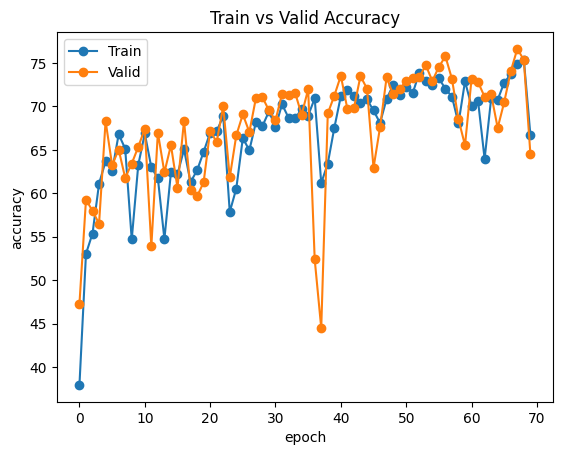

In [ ]:
#plot accuracy
plt.plot(train_accu,'-o')
plt.plot(eval_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

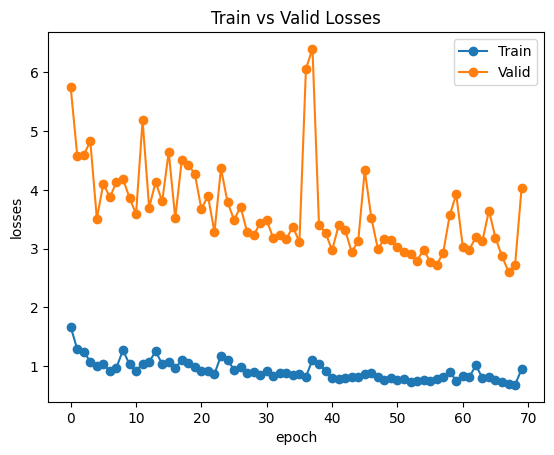

In [ ]:
#plot losses

plt.plot(train_losses,'-o')
plt.plot(eval_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')

plt.show()

In [ ]:
# testing
ttloss = []
ttacc = []
ttf1 = []

T_val = []
P_val = []

with torch.no_grad():
    model.eval()
    for X_val, y_val, _ in tqdm(test_loader):
        X_val = X_val.float().cuda()
        X_val, y_val = X_val.to(device), y_val.to(device)
        #y_val = y_val.type(torch.cuda.LongTensor)

        output = model(X_val)
        #print(output.shape)

        outputs = torch.max(output, dim=1)[1]
        #print(outputs.shape)
        T_val.extend(y_val.cpu().numpy())
        #print(T_val)
        P_val.extend(outputs.cpu().numpy())
    #print(T_val)
    #print(P_val)
    precision = precision_score(T_val, P_val, average='macro')
    recall = recall_score(T_val, P_val, average='macro')
    res = confusion_matrix(T_val, P_val)
    report = classification_report(T_val, P_val)

    print("Precision: ",precision)
    print("Recall: ",recall)

    print('Confusion matrix:\n',res)
    print('Report:\n',report)


# with torch.no_grad():
#     model.eval()
#     for id, (X_val, y_val) in enumerate(val_data):
#         X_val, y_val = X_val.to(device), y_val.to(device)
#         y_val = y_val.type(torch.cuda.LongTensor)

#         output = model(X_val)
#         outputs = torch.max(output, dim=1)[1]
#         T_val.extend(y_val.cpu().numpy())
#         P_val.extend(outputs.cpu().numpy())
#     print(T_val)
#     print(P_val)
#     precision = precision_score(T_val, P_val, average='macro')
#     recall = recall_score(T_val, P_val, average='macro')
#     res = confusion_matrix(T_val, P_val)
#     report = classification_report(T_val, P_val)

#     print("Precision: ",precision)
#     print("Recall: ",recall)

#     print('Confusion matrix:\n',res)
#     print('Report:\n',report)

100%|██████████| 169/169 [00:02<00:00, 57.40it/s]

Precision:  0.6613740469593626
Recall:  0.6300666666666667
Confusion matrix:
 [[485   1  23  27   1   7   7  15  15  19]
 [  4 488   7  12   0  23   0   4   1  61]
 [ 27   5 364   9   8  11  26 123   1  26]
 [ 71   1  69 205  26  10  10  74  31   3]
 [  5   0  10  21 387   0   0  77   0   0]
 [ 26   2   5  60   0 242  17  23  14  11]
 [ 88   1 110  59   9   3 124  94   6   6]
 [ 16   0  66  22   9   5  13 465   1   3]
 [ 26   4  73 115   5  27   9  23 201  17]
 [  3  50   8   0   0  17   0   3   4 515]]
Report:
               precision    recall  f1-score   support

           0       0.65      0.81      0.72       600
           1       0.88      0.81      0.85       600
           2       0.50      0.61      0.55       600
           3       0.39      0.41      0.40       500
           4       0.87      0.77      0.82       500
           5       0.70      0.60      0.65       400
           6       0.60      0.25      0.35       500
           7       0.52      0.78      0.62      

##Watermark Detection CNN

In [ ]:
class WatermarkDetectorCNN(nn.Module):
    def __init__(self):
        super(WatermarkDetectorCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        # The feature map size depends on your input image size. Assuming an input size of (3, 64, 64),
        # the output size here would be (128, 8, 8) after three rounds of max pooling (2, 2) starting from 64x64.
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 8 * 8, 512),  # 128 channels, each 8x8 from the last pooling
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 2) # Output layer for binary classification
        )
    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, start_dim=1)  # Flatten all dimensions except batch
        x = self.fc_layers(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = WatermarkDetectorCNN().to(device)
# Initialize the CrossEntropyLoss function
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


# Training loop
model.train()  # Set the model to training mode
num_epochs = 100
epoch_losses = []
all_labels = []
all_scores = []


for epoch in range(num_epochs):
    batch_losses = []
    for images, _, watermark_labels in tqdm(train_loader):  # Adjusted to ignore landscape labels
        images = images.to(device)
        watermark_labels = watermark_labels.to(device)  # Ensure labels are long integers
        watermark_labels = watermark_labels.long()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, watermark_labels)  # Labels are class indices
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()

        batch_losses.append(loss.item())

    # Calculate and store the average loss for this epoch
    epoch_losses = np.mean(batch_losses)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_losses:.4f}')

100%|██████████| 675/675 [00:08<00:00, 83.84it/s]


Epoch [1/100], Loss: 0.6942


100%|██████████| 675/675 [00:07<00:00, 89.77it/s]


Epoch [2/100], Loss: 0.6934


100%|██████████| 675/675 [00:07<00:00, 89.56it/s]


Epoch [3/100], Loss: 0.6930


100%|██████████| 675/675 [00:07<00:00, 89.72it/s]


Epoch [4/100], Loss: 0.6919


100%|██████████| 675/675 [00:07<00:00, 89.76it/s]


Epoch [5/100], Loss: 0.6888


100%|██████████| 675/675 [00:07<00:00, 89.86it/s]


Epoch [6/100], Loss: 0.6828


100%|██████████| 675/675 [00:07<00:00, 89.32it/s]


Epoch [7/100], Loss: 0.6687


100%|██████████| 675/675 [00:07<00:00, 90.39it/s]


Epoch [8/100], Loss: 0.6465


100%|██████████| 675/675 [00:07<00:00, 89.85it/s]


Epoch [9/100], Loss: 0.6195


100%|██████████| 675/675 [00:07<00:00, 89.94it/s]


Epoch [10/100], Loss: 0.5891


100%|██████████| 675/675 [00:07<00:00, 89.36it/s]


Epoch [11/100], Loss: 0.5565


100%|██████████| 675/675 [00:07<00:00, 89.76it/s]


Epoch [12/100], Loss: 0.5224


100%|██████████| 675/675 [00:07<00:00, 90.40it/s]


Epoch [13/100], Loss: 0.4876


100%|██████████| 675/675 [00:07<00:00, 89.91it/s]


Epoch [14/100], Loss: 0.4521


100%|██████████| 675/675 [00:07<00:00, 89.21it/s]


Epoch [15/100], Loss: 0.4117


100%|██████████| 675/675 [00:07<00:00, 89.56it/s]


Epoch [16/100], Loss: 0.3752


100%|██████████| 675/675 [00:07<00:00, 89.75it/s]


Epoch [17/100], Loss: 0.3332


100%|██████████| 675/675 [00:07<00:00, 89.00it/s]


Epoch [18/100], Loss: 0.2950


100%|██████████| 675/675 [00:07<00:00, 89.77it/s]


Epoch [19/100], Loss: 0.2607


100%|██████████| 675/675 [00:07<00:00, 90.25it/s]


Epoch [20/100], Loss: 0.2284


100%|██████████| 675/675 [00:07<00:00, 89.59it/s]


Epoch [21/100], Loss: 0.1947


100%|██████████| 675/675 [00:07<00:00, 89.86it/s]


Epoch [22/100], Loss: 0.1661


100%|██████████| 675/675 [00:07<00:00, 91.41it/s]


Epoch [23/100], Loss: 0.1406


100%|██████████| 675/675 [00:07<00:00, 90.54it/s]


Epoch [24/100], Loss: 0.1201


100%|██████████| 675/675 [00:07<00:00, 90.88it/s]


Epoch [25/100], Loss: 0.1043


100%|██████████| 675/675 [00:07<00:00, 90.42it/s]


Epoch [26/100], Loss: 0.0912


100%|██████████| 675/675 [00:07<00:00, 90.53it/s]


Epoch [27/100], Loss: 0.0841


100%|██████████| 675/675 [00:07<00:00, 91.09it/s]


Epoch [28/100], Loss: 0.0718


100%|██████████| 675/675 [00:07<00:00, 89.73it/s]


Epoch [29/100], Loss: 0.0657


100%|██████████| 675/675 [00:07<00:00, 90.27it/s]


Epoch [30/100], Loss: 0.0590


100%|██████████| 675/675 [00:07<00:00, 90.42it/s]


Epoch [31/100], Loss: 0.0551


100%|██████████| 675/675 [00:07<00:00, 89.50it/s]


Epoch [32/100], Loss: 0.0513


100%|██████████| 675/675 [00:07<00:00, 90.48it/s]


Epoch [33/100], Loss: 0.0483


100%|██████████| 675/675 [00:07<00:00, 91.02it/s]


Epoch [34/100], Loss: 0.0404


100%|██████████| 675/675 [00:07<00:00, 89.87it/s]


Epoch [35/100], Loss: 0.0418


100%|██████████| 675/675 [00:07<00:00, 90.31it/s]


Epoch [36/100], Loss: 0.0411


100%|██████████| 675/675 [00:07<00:00, 90.77it/s]


Epoch [37/100], Loss: 0.0349


100%|██████████| 675/675 [00:07<00:00, 91.17it/s]


Epoch [38/100], Loss: 0.0348


100%|██████████| 675/675 [00:07<00:00, 89.85it/s]


Epoch [39/100], Loss: 0.0352


100%|██████████| 675/675 [00:07<00:00, 90.37it/s]


Epoch [40/100], Loss: 0.0364


100%|██████████| 675/675 [00:07<00:00, 90.12it/s]


Epoch [41/100], Loss: 0.0302


100%|██████████| 675/675 [00:07<00:00, 89.76it/s]


Epoch [42/100], Loss: 0.0264


100%|██████████| 675/675 [00:07<00:00, 90.79it/s]


Epoch [43/100], Loss: 0.0255


100%|██████████| 675/675 [00:07<00:00, 89.96it/s]


Epoch [44/100], Loss: 0.0275


100%|██████████| 675/675 [00:07<00:00, 88.98it/s]


Epoch [45/100], Loss: 0.0293


100%|██████████| 675/675 [00:07<00:00, 91.24it/s]


Epoch [46/100], Loss: 0.0256


100%|██████████| 675/675 [00:07<00:00, 89.56it/s]


Epoch [47/100], Loss: 0.0268


100%|██████████| 675/675 [00:07<00:00, 89.95it/s]


Epoch [48/100], Loss: 0.0238


100%|██████████| 675/675 [00:07<00:00, 91.29it/s]


Epoch [49/100], Loss: 0.0220


100%|██████████| 675/675 [00:07<00:00, 90.22it/s]


Epoch [50/100], Loss: 0.0242


100%|██████████| 675/675 [00:07<00:00, 90.34it/s]


Epoch [51/100], Loss: 0.0271


100%|██████████| 675/675 [00:07<00:00, 91.54it/s]


Epoch [52/100], Loss: 0.0215


100%|██████████| 675/675 [00:07<00:00, 90.39it/s]


Epoch [53/100], Loss: 0.0228


100%|██████████| 675/675 [00:07<00:00, 90.46it/s]


Epoch [54/100], Loss: 0.0183


100%|██████████| 675/675 [00:07<00:00, 87.78it/s]


Epoch [55/100], Loss: 0.0234


100%|██████████| 675/675 [00:07<00:00, 87.89it/s]


Epoch [56/100], Loss: 0.0217


100%|██████████| 675/675 [00:07<00:00, 90.53it/s]


Epoch [57/100], Loss: 0.0191


100%|██████████| 675/675 [00:07<00:00, 90.46it/s]


Epoch [58/100], Loss: 0.0196


100%|██████████| 675/675 [00:07<00:00, 89.54it/s]


Epoch [59/100], Loss: 0.0211


100%|██████████| 675/675 [00:07<00:00, 90.37it/s]


Epoch [60/100], Loss: 0.0192


100%|██████████| 675/675 [00:07<00:00, 90.19it/s]


Epoch [61/100], Loss: 0.0195


100%|██████████| 675/675 [00:07<00:00, 90.94it/s]


Epoch [62/100], Loss: 0.0201


100%|██████████| 675/675 [00:07<00:00, 90.13it/s]


Epoch [63/100], Loss: 0.0177


100%|██████████| 675/675 [00:07<00:00, 90.79it/s]


Epoch [64/100], Loss: 0.0222


100%|██████████| 675/675 [00:07<00:00, 90.27it/s]


Epoch [65/100], Loss: 0.0189


100%|██████████| 675/675 [00:07<00:00, 88.88it/s]


Epoch [66/100], Loss: 0.0169


100%|██████████| 675/675 [00:07<00:00, 90.22it/s]


Epoch [67/100], Loss: 0.0151


100%|██████████| 675/675 [00:07<00:00, 89.86it/s]


Epoch [68/100], Loss: 0.0176


100%|██████████| 675/675 [00:07<00:00, 89.16it/s]


Epoch [69/100], Loss: 0.0183


100%|██████████| 675/675 [00:07<00:00, 89.55it/s]


Epoch [70/100], Loss: 0.0146


100%|██████████| 675/675 [00:07<00:00, 89.88it/s]


Epoch [71/100], Loss: 0.0193


100%|██████████| 675/675 [00:07<00:00, 89.51it/s]


Epoch [72/100], Loss: 0.0151


100%|██████████| 675/675 [00:07<00:00, 88.66it/s]


Epoch [73/100], Loss: 0.0178


100%|██████████| 675/675 [00:07<00:00, 87.64it/s]


Epoch [74/100], Loss: 0.0164


100%|██████████| 675/675 [00:07<00:00, 89.91it/s]


Epoch [75/100], Loss: 0.0172


100%|██████████| 675/675 [00:07<00:00, 89.75it/s]


Epoch [76/100], Loss: 0.0160


100%|██████████| 675/675 [00:07<00:00, 88.46it/s]


Epoch [77/100], Loss: 0.0181


100%|██████████| 675/675 [00:07<00:00, 89.78it/s]


Epoch [78/100], Loss: 0.0141


100%|██████████| 675/675 [00:07<00:00, 91.36it/s]


Epoch [79/100], Loss: 0.0141


100%|██████████| 675/675 [00:07<00:00, 91.06it/s]


Epoch [80/100], Loss: 0.0211


100%|██████████| 675/675 [00:07<00:00, 90.71it/s]


Epoch [81/100], Loss: 0.0150


100%|██████████| 675/675 [00:07<00:00, 91.04it/s]


Epoch [82/100], Loss: 0.0147


100%|██████████| 675/675 [00:07<00:00, 91.09it/s]


Epoch [83/100], Loss: 0.0134


100%|██████████| 675/675 [00:07<00:00, 92.08it/s]


Epoch [84/100], Loss: 0.0175


100%|██████████| 675/675 [00:07<00:00, 90.96it/s]


Epoch [85/100], Loss: 0.0128


100%|██████████| 675/675 [00:07<00:00, 90.44it/s]


Epoch [86/100], Loss: 0.0156


100%|██████████| 675/675 [00:07<00:00, 91.17it/s]


Epoch [87/100], Loss: 0.0162


100%|██████████| 675/675 [00:07<00:00, 90.67it/s]


Epoch [88/100], Loss: 0.0132


100%|██████████| 675/675 [00:07<00:00, 90.40it/s]


Epoch [89/100], Loss: 0.0174


100%|██████████| 675/675 [00:07<00:00, 91.28it/s]


Epoch [90/100], Loss: 0.0147


100%|██████████| 675/675 [00:07<00:00, 91.02it/s]


Epoch [91/100], Loss: 0.0191


100%|██████████| 675/675 [00:07<00:00, 90.72it/s]


Epoch [92/100], Loss: 0.0103


100%|██████████| 675/675 [00:07<00:00, 91.01it/s]


Epoch [93/100], Loss: 0.0141


100%|██████████| 675/675 [00:07<00:00, 91.89it/s]


Epoch [94/100], Loss: 0.0115


100%|██████████| 675/675 [00:07<00:00, 91.32it/s]


Epoch [95/100], Loss: 0.0192


100%|██████████| 675/675 [00:07<00:00, 91.11it/s]


Epoch [96/100], Loss: 0.0161


100%|██████████| 675/675 [00:07<00:00, 90.46it/s]


Epoch [97/100], Loss: 0.0116


100%|██████████| 675/675 [00:07<00:00, 89.77it/s]


Epoch [98/100], Loss: 0.0117


100%|██████████| 675/675 [00:07<00:00, 91.21it/s]


Epoch [99/100], Loss: 0.0120


100%|██████████| 675/675 [00:07<00:00, 90.65it/s]

Epoch [100/100], Loss: 0.0159


### Analysis of Watermark Detection Model

In [ ]:
_, predicted = torch.max(outputs, 1)  # Get the predicted classes
accuracy = (predicted == watermark_labels).float().mean()  # Calculate accuracy


100%|██████████| 675/675 [00:05<00:00, 115.71it/s]


Accuracy: 0.9996296296296296
Precision: 0.9995389580451821
Recall: 0.9997233238033755
F1 Score: 0.9996311324234599
AUC Score: 0.9996292550968165


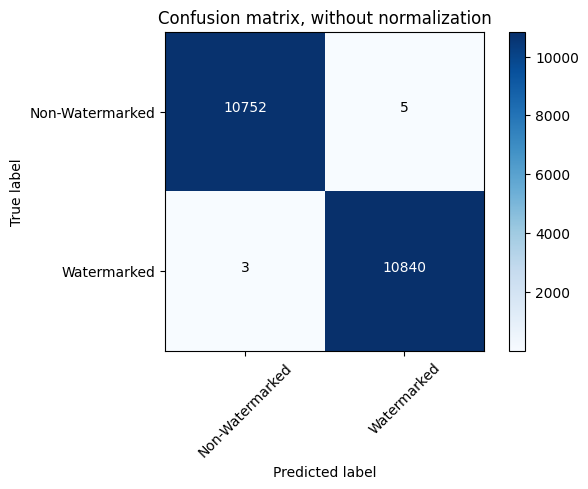

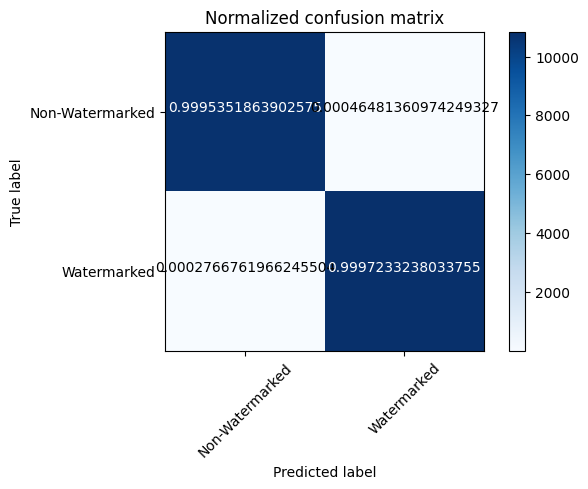

In [ ]:
# Assuming you have 'test_loader' ready and the model is trained and moved to the correct device
model.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for images, _, watermark_labels in tqdm(train_loader):
        images = images.to(device)
        watermark_labels = watermark_labels.to(device)  # Ensure labels are long integers
        watermark_labels = watermark_labels.long()
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(watermark_labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
auc = roc_auc_score(all_labels, all_preds)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("AUC Score:", auc)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(all_labels, all_preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Non-Watermarked', 'Watermarked'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Non-Watermarked', 'Watermarked'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Save Watermarked Images

In [ ]:
def save_dataset_images(dataset, root_dir):
    labels = ['Forest', 'HerbaceousVegetation', 'AnnualCrop', 'Industrial', 'PermanentCrop', 'SeaLake', 'Residential', 'River', 'Pasture', 'Highway']

    # Ensure directory structure
    for label in labels:
        os.makedirs(os.path.join(root_dir, label, "watermarked"), exist_ok=True)
        os.makedirs(os.path.join(root_dir, label, "non_watermarked"), exist_ok=True)

    pbar = tqdm(enumerate(dataset), total=len(dataset), desc="Saving images")

    for i, (image_tensor, landscape_label, watermark_label) in pbar:
        label_name = labels[landscape_label]
        subfolder = "watermarked" if watermark_label else "non_watermarked"
        jpeg_path = os.path.join(root_dir, label_name, subfolder, f"{i}.jpeg")

        # Convert the PyTorch tensor to a NumPy array
        image_np = image_tensor.numpy()

        # Normalize and save the image as JPEG
        rgb_image = np.transpose(image_np, (1, 2, 0))  # Change to HxWxC
        rgb_image = (rgb_image * 255).astype(np.uint8)
        im = Image.fromarray(rgb_image)
        im.save(jpeg_path)

root_dir = "/content/eurosat/2750"  # Make sure this is correctly set
save_dataset_images(train_dataset, root_dir)

Saving images: 100%|██████████| 21600/21600 [00:11<00:00, 1925.07it/s]


## GAN Image Model

### Call Dataset from Watermarked and Non Watermarked

In [ ]:
#Create folder for generated images
gen_dir_path = '/content/eurosat/2750/generated'
os.makedirs(gen_dir_path, exist_ok=True)

In [ ]:
class Watermarked_Dataset(Dataset):
    def __init__(self, root_dir, categories, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.files = []
        self.labels = []

        for category in categories:
          # Paths to watermarked and non_watermarked subdirectories within each category
          watermarked_dir = os.path.join(root_dir, category, 'watermarked')
          non_watermarked_dir = os.path.join(root_dir, category, 'non_watermarked')

          # Check for watermarked directory and add images
          if os.path.exists(watermarked_dir):
              for file in os.listdir(watermarked_dir):
                  if file.endswith('.jpeg'):
                      file_path = os.path.join(watermarked_dir, file)
                      self.files.append(file_path)
                      self.labels.append(1)  # 1 for watermarked

          # Check for non_watermarked directory and add images
          if os.path.exists(non_watermarked_dir):
              for file in os.listdir(non_watermarked_dir):
                  if file.endswith('.jpeg'):
                      file_path = os.path.join(non_watermarked_dir, file)
                      self.files.append(file_path)
                      self.labels.append(0)  # 0 for non_watermarked

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        label = self.labels[idx]

        # Load image with PIL
        image = Image.open(img_path)

        # Convert the image to a PyTorch tensor
        image = transforms.ToTensor()(image)

        # Normalize the image if a transform is provided
        if self.transform:
            image = self.transform(image)  # Apply the transform

        return image, label

# Define the normalization transform
transform = transforms.Compose([
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

category_names = ['AnnualCrop', 'HerbaceousVegetation', 'Forest', 'Pasture', 'Industrial',
                  'SeaLake', 'PermanentCrop', 'Residential', 'River', 'Highway']

In [ ]:
root_dir = '/content/eurosat/2750/'
watermarked_dataset = Watermarked_Dataset(root_dir, category_names, transform=transform)
train_loader = DataLoader(watermarked_dataset, batch_size=32, shuffle=True)


In [ ]:
print(f'Total images: {len(watermarked_dataset)}')
print(f'Total images: {len(train_loader)}')

Total images: 21600
Total images: 675


In [ ]:
# Get the first image and label from the dataset
image, label = watermarked_dataset[0]

# Print the shape; it should be in (C, H, W) format if you've already transposed it
print(image.shape)
# Check what the dataset returns directly
sample_image, sample_label = watermarked_dataset[0]
print(sample_image.shape)  # This should print (3, 64, 64) or similar
# Check the first batch from the DataLoader
for images, labels in train_loader:
    print(images.shape)
    print(type(images))  # Ensure this is a tensor
    break


torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([32, 3, 64, 64])
<class 'torch.Tensor'>


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 16

In [ ]:
image_shape = (3, 64, 64)
image_dim = int(np.prod(image_shape))
latent_dim = 100

In [ ]:
num_class = len(train_loader.dataset.labels)
print('Training samples: ', len(train_loader)*batch_size)
print('number of batches: ', len(train_loader))

Training samples:  10800
number of batches:  675


In [ ]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [ ]:
def show_images(images):
    fig, ax = plt.subplots(figsize=(20, 20))
    if images.max() > 1.0 or images.min() < 0.0:
            images = (images - images.min()) / (images.max() - images.min())
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach(), nrow=22).permute(1, 2, 0))

def show_batch(dl):
    for images, _ in dl:
        show_images(images)
        break

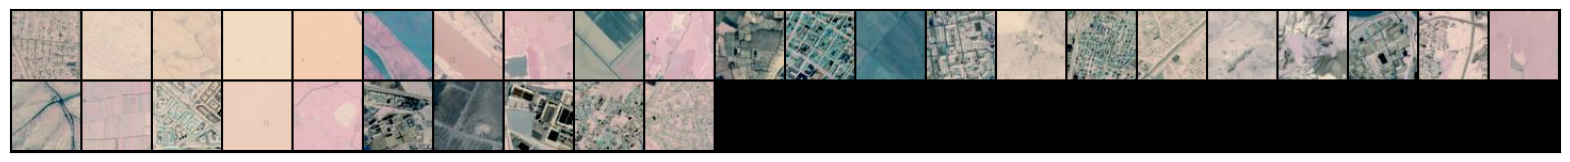

In [ ]:
show_batch(train_loader)

### Load GAN Model

In [ ]:
# Generator Model Class Definition
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Block 1:input is Z, going into a convolution
            nn.ConvTranspose2d(latent_dim, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            # Block 2: input is (64 * 8) x 4 x 4
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            # Block 3: input is (64 * 4) x 8 x 8
            nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            # Block 4: input is (64 * 2) x 16 x 16
            nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # Block 5: input is (64) x 32 x 32
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # Output: output is (3) x 64 x 64
            )
    def forward(self, input):
        output = self.main(input)
        return output

In [ ]:
# Discriminator Model Class Definition
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Block 1: input is (3) x 64 x 64
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # Block 2: input is (64) x 32 x 32
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # Block 3: input is (64*2) x 16 x 16
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # Block 4: input is (64*4) x 8 x 8
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # Block 5: input is (64*8) x 4 x 4
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
            nn.Flatten()
            # Output: 1
            )
    def forward(self, input):
        output = self.main(input)
        return output

In [ ]:
generator = Generator().to(device)
generator.apply(weights_init_normal)
print(generator)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:
discriminator = Discriminator().to(device)
discriminator.apply(weights_init_normal)
print(discriminator)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
    (13): Flatten(start_dim=1, end_d

In [ ]:
summary(generator, (100,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

In [ ]:
summary(discriminator, (3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,072
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,288
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
           Conv2d-12              [-1, 1, 1, 1]           8,192
          Sigmoid-13              [-1, 1, 1, 1]               0
          Flatten-14                   

In [ ]:
adversarial_loss = nn.BCELoss()

In [ ]:
def generator_loss(fake_output, label):
    gen_loss = adversarial_loss(fake_output, label)
    #print(gen_loss)
    return gen_loss

In [ ]:
def discriminator_loss(output, label):
    disc_loss = adversarial_loss(output, label)
    return disc_loss

In [ ]:
fixed_noise = torch.randn(128, latent_dim, 1, 1, device=device)
real_label = 1
fake_label = 0

In [ ]:
learning_rate = 0.0002
G_optimizer = optim.Adam(generator.parameters(), lr = learning_rate, betas=(0.5, 0.999))
D_optimizer = optim.Adam(discriminator.parameters(), lr = learning_rate, betas=(0.5, 0.999))

### Run GAN Model

In [ ]:
num_epochs = 300
D_loss_plot, G_loss_plot = [], []

for epoch in range(1, num_epochs+1):
    D_loss_list, G_loss_list = [], []

    # Adjust enumeration to unpack all items from the loader
    for index, (real_images, _) in enumerate(train_loader):
        D_optimizer.zero_grad()
        real_images = real_images.to(device)

        # Prepare targets for the discriminator
        real_target = Variable(torch.ones(real_images.size(0), 1).to(device))  # Real images
        fake_target = Variable(torch.zeros(real_images.size(0), 1).to(device))  # Fake images

        # Discriminator loss on real images
        D_real_loss = discriminator_loss(discriminator(real_images), real_target)
        D_real_loss.backward()

        # Generate fake images
        noise_vector = torch.randn(real_images.size(0), latent_dim, 1, 1, device=device)
        generated_image = generator(noise_vector)

        # Discriminator loss on fake images
        output = discriminator(generated_image.detach())
        D_fake_loss = discriminator_loss(output, fake_target)
        D_fake_loss.backward()

        D_total_loss = D_real_loss + D_fake_loss
        D_loss_list.append(D_total_loss.item())

        D_optimizer.step()

        # Generator training
        G_optimizer.zero_grad()
        G_loss = generator_loss(discriminator(generated_image), real_target)
        G_loss.backward()
        G_optimizer.step()
        G_loss_list.append(G_loss.item())

    # Logging
    print(f'Epoch: [{epoch}/{num_epochs}]: D_loss: {np.mean(D_loss_list):.3f}, G_loss: {np.mean(G_loss_list):.3f}')
    D_loss_plot.append(np.mean(D_loss_list))
    G_loss_plot.append(np.mean(G_loss_list))

    # Saving generated images and model at the last epoch
    if epoch == 300:
        for i in range(generated_image.shape[0]):
            save_image(generated_image[i], f'/content/eurosat/2750/generated/{i}.png', normalize=True)
        torch.save(generator.state_dict(), f'/content/eurosat/2750/generator_epoch_{epoch}.pth')
        torch.save(discriminator.state_dict(), f'/content/eurosat/2750/discriminator_epoch_{epoch}.pth')

Epoch: [1/300]: D_loss: 0.558, G_loss: 6.454
Epoch: [2/300]: D_loss: 0.750, G_loss: 3.406
Epoch: [3/300]: D_loss: 0.839, G_loss: 3.356
Epoch: [4/300]: D_loss: 0.823, G_loss: 3.248
Epoch: [5/300]: D_loss: 0.714, G_loss: 3.547
Epoch: [6/300]: D_loss: 0.664, G_loss: 3.787
Epoch: [7/300]: D_loss: 0.559, G_loss: 3.999
Epoch: [8/300]: D_loss: 0.473, G_loss: 4.180
Epoch: [9/300]: D_loss: 0.557, G_loss: 4.260
Epoch: [10/300]: D_loss: 0.463, G_loss: 4.340
Epoch: [11/300]: D_loss: 0.438, G_loss: 4.320
Epoch: [12/300]: D_loss: 0.387, G_loss: 4.753
Epoch: [13/300]: D_loss: 0.396, G_loss: 4.832
Epoch: [14/300]: D_loss: 0.394, G_loss: 4.701
Epoch: [15/300]: D_loss: 0.353, G_loss: 4.849
Epoch: [16/300]: D_loss: 0.373, G_loss: 4.962
Epoch: [17/300]: D_loss: 0.343, G_loss: 4.803
Epoch: [18/300]: D_loss: 0.308, G_loss: 4.962
Epoch: [19/300]: D_loss: 0.312, G_loss: 5.135
Epoch: [20/300]: D_loss: 0.339, G_loss: 5.159
Epoch: [21/300]: D_loss: 0.231, G_loss: 5.318
Epoch: [22/300]: D_loss: 0.376, G_loss: 5.2

## Save Final Results

## Save Generated Images

In [ ]:
def zip_all_png(directory_path, zip_file_path):
    # Create a ZipFile object in write mode
    with zipfile.ZipFile(zip_file_path, 'w') as zipf:
        # Walk through the directory
        for foldername, subfolders, filenames in os.walk(directory_path):
            for filename in filenames:
                # Check if the file is a PNG
                if filename.endswith('.png'):
                    # Create the complete filepath of the file in directory
                    file_path = os.path.join(foldername, filename)
                    # Add file to the zip file
                    zipf.write(file_path, arcname=filename)

# Usage
directory_to_zip = '/content/eurosat/2750/generated'
zip_output_path = '/content/generated_images.zip'
zip_all_png(directory_to_zip, zip_output_path)

### Save All Files

In [ ]:
def zip_all_files(directory_path, zip_file_path):
    # Create a ZipFile object in write mode
    with zipfile.ZipFile(zip_file_path, 'w') as zipf:
        # Walk through the directory
        for foldername, subfolders, filenames in os.walk(directory_path):
            for filename in filenames:
                # Create the complete filepath of the file in directory
                file_path = os.path.join(foldername, filename)
                # Define the archive name to be the path relative to the directory being zipped
                arcname = os.path.relpath(file_path, directory_path)
                # Add file to the zip file
                zipf.write(file_path, arcname=arcname)

# Usage
directory_to_zip = '/content/eurosat/2750'
zip_output_path = '/content/fulldataset.zip'
zip_all_files(directory_to_zip, zip_output_path)